# Regression Deep Learning Model for [PROJECT NAME] Using TensorFlow Version 7
### David Lowe
### July 13, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The [PROJECT NAME] dataset is a regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: [Sample Paragraph - The purpose of the analysis is to predict the housing values in the suburbs of Boston by using the home sale transaction history.]

ANALYSIS: [Sample Paragraph - The performance of the baseline model achieved a root mean squared error (RMSE) of 7.67 after 50 epochs using the training dataset. After tuning the hyperparameters, the best model processed the validation dataset with an RMSE of 2.66. Furthermore, the final model processed the test dataset with an RMSE of 2.66, which was consistent with the training/tuning phase.]

CONCLUSION: For this dataset, the model built using TensorFlow achieved a satisfactory result and should be considered for future modeling activities.

Dataset Used: [PROJECT NAME] Dataset

Dataset ML Model: Regression with [numerical | categorical] attributes

Dataset Reference: [https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.data]

One potential source of performance benchmarks: [https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/]

A deep-learning modeling project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Data
3. Define and Train Model
4. Evaluate and Optimize Model
5. Finalize Model and Make Predictions

# Task 1. Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve GPU configuration information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# Retrieve memory configuration information from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Direct Colab to use TensorFlow v2
# %tensorflow_version 2.x

In [5]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


In [6]:
# Set the random seed number for reproducible results
seedNum = 888

In [7]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import math
import boto3
from datetime import datetime
from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [8]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Check the number of GPUs accessible through TensorFlow
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useGDrive = False
if useGDrive:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_loss = 'mean_squared_error'
default_optimizer = tf.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.initializers.he_uniform(seed=seedNum)
default_epoch = 50
default_batch = 16

# Define the labels to use for graphing the data
train_metric = "loss"
validation_metric = "val_loss"

Num GPUs Available:  0


In [9]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = "arn:aws:sns:us-east-1:072417399597:PythonMLScriptNotification"
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [10]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [11]:
if (notifyStatus): status_notify("Task 1. Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 2. Load and Prepare Data

In [12]:
if (notifyStatus): status_notify("Task 2. Load and Prepare Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 2.a) Load Dataset

In [13]:
dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data'
colNames = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
Xy_original = pd.read_csv(dataset_path, names=colNames, delim_whitespace=True, header=None)

# Take a peek at the dataframe after the import
Xy_original.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


In [14]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [15]:
null_counts = Xy_original.isnull().sum()
null_counts[null_counts > 0]

Series([], dtype: int64)

In [16]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


## 2.b) Data Cleaning

In [17]:
# Standardize the class column to the name of targetVar if required
Xy_original = Xy_original.rename(columns={'MEDV': 'targetVar'})

# Dropping features
# Xy_original.drop(columns=['attribute_name'], inplace=True)

# Impute missing values
# Xy_original['col_name'].fillna('someValue', inplace=True)
# Xy_original['attribute_name'].fillna(value=Xy_original['attribute_name'].median(), inplace=True)

# Convert columns from one data type to another
# Xy_original.column_name = Xy_original.column_name.astype('int')
# Xy_original.column_name = Xy_original.column_name.astype('category')
Xy_original['CHAS'] = Xy_original['CHAS'].astype('float')
Xy_original['RAD'] = Xy_original['RAD'].astype('float')

# Convert features with Y/N levels into categorical feature of 1/0
# def reClassSomecol(target):
#     if (target == 'Y'): return 1
#     else: return 0
# Xy_original['targetVar'] = Xy_original['target'].apply(reClassSomecol)
# Xy_original.drop(columns=['target'], inplace=True)

# Take a peek at the dataframe after the cleaning
Xy_original.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,targetVar
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


In [18]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CRIM       506 non-null    float64
 1   ZN         506 non-null    float64
 2   INDUS      506 non-null    float64
 3   CHAS       506 non-null    float64
 4   NOX        506 non-null    float64
 5   RM         506 non-null    float64
 6   AGE        506 non-null    float64
 7   DIS        506 non-null    float64
 8   RAD        506 non-null    float64
 9   TAX        506 non-null    float64
 10  PTRATIO    506 non-null    float64
 11  B          506 non-null    float64
 12  LSTAT      506 non-null    float64
 13  targetVar  506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [19]:
null_counts = Xy_original.isnull().sum()
null_counts[null_counts > 0]

Series([], dtype: int64)

In [20]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


## 2.c) Feature Scaling and Pre-processing

In [21]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [22]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (506, 14) X_original.shape: (506, 13) y_original.shape: (506,)


In [23]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

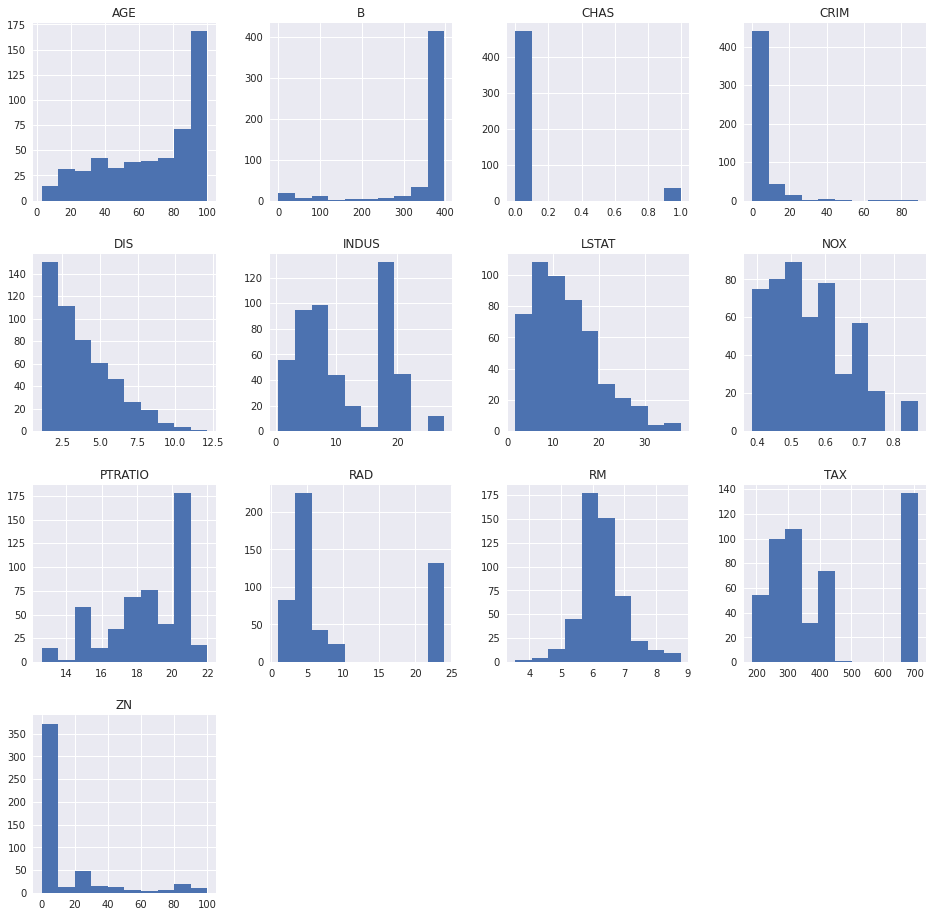

In [24]:
# Histograms for each attribute before pre-processing
columns_to_scale = X_original.columns[X_original.dtypes == 'float64'].tolist()
X_original[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

In [25]:
# Apply feature scaling and transformation
print('Columns to scale are:', columns_to_scale)
scaler = preprocessing.StandardScaler()
X_original[columns_to_scale] = scaler.fit_transform(X_original[columns_to_scale])
print(X_original.head())

Columns to scale are: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
       CRIM        ZN     INDUS      CHAS       NOX        RM       AGE       DIS       RAD       TAX   PTRATIO         B     LSTAT
0 -0.419782  0.284830 -1.287909 -0.272599 -0.144217  0.413672 -0.120013  0.140214 -0.982843 -0.666608 -1.459000  0.441052 -1.075562
1 -0.417339 -0.487722 -0.593381 -0.272599 -0.740262  0.194274  0.367166  0.557160 -0.867883 -0.987329 -0.303094  0.441052 -0.492439
2 -0.417342 -0.487722 -0.593381 -0.272599 -0.740262  1.282714 -0.265812  0.557160 -0.867883 -0.987329 -0.303094  0.396427 -1.208727
3 -0.416750 -0.487722 -1.306878 -0.272599 -0.835284  1.016303 -0.809889  1.077737 -0.752922 -1.106115  0.113032  0.416163 -1.361517
4 -0.412482 -0.487722 -1.306878 -0.272599 -0.835284  1.228577 -0.511180  1.077737 -0.752922 -1.106115  0.113032  0.441052 -1.026501


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

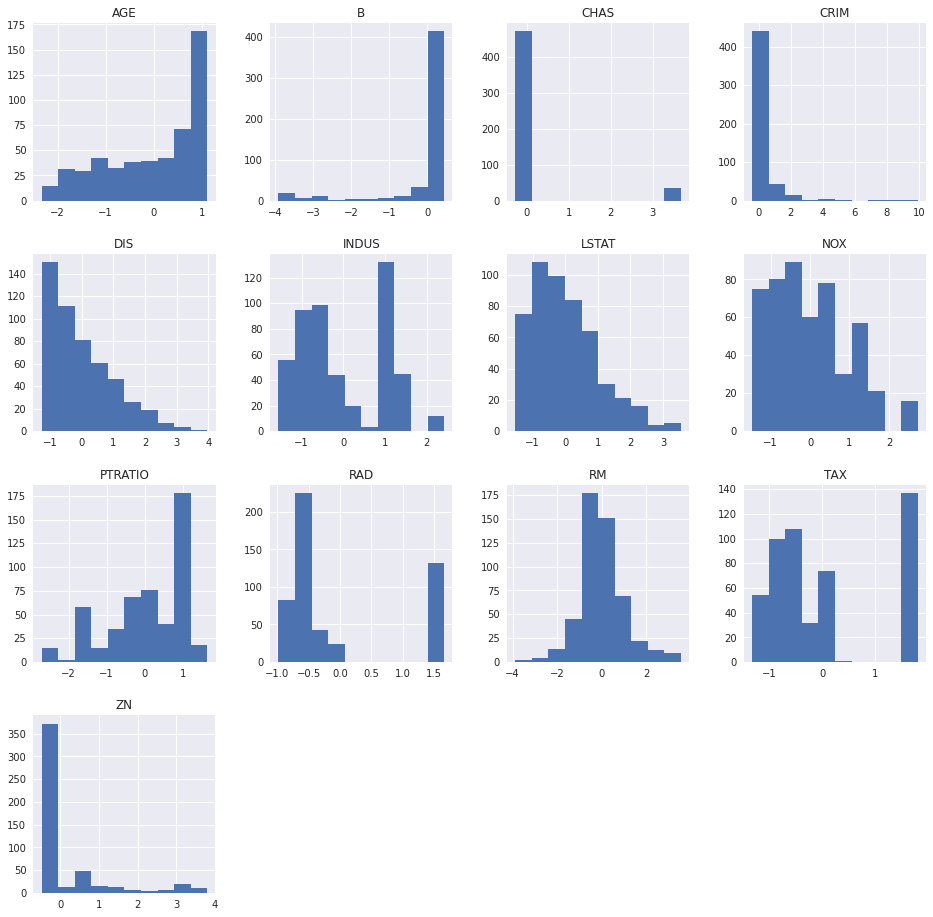

In [26]:
# Histograms for each attribute after pre-processing
X_original[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

## 2.d) Splitting Data into Training and Test Sets

In [27]:
# Perform one-hot-encoding before splitting into trainig and test
# X_original = pd.get_dummies(X_original)
# print(X_original.info())

In [28]:
X_encoded = X_original.to_numpy()
y_encoded = y_original.to_numpy()
if (splitDataset):
    X_train, X_validation, y_train, y_validation = train_test_split(X_encoded, y_encoded, test_size=splitPercentage, random_state=seedNum)
else:
    X_train, y_train = X_encoded, y_encoded
    X_validation, y_validation = X_encoded, y_encoded
print("X_train.shape: {} X_train.type: {}".format(X_train.shape, type(X_train)))
print("y_train.shape: {} y_train.type: {}".format(y_train.shape, type(y_train)))
print("X_validation.shape: {} X_validation.type: {}".format(X_validation.shape, type(X_validation)))
print("y_validation.shape: {} y_validation.type: {}".format(y_validation.shape, type(y_validation)))

X_train.shape: (379, 13) X_train.type: <class 'numpy.ndarray'>
y_train.shape: (379,) y_train.type: <class 'numpy.ndarray'>
X_validation.shape: (127, 13) X_validation.type: <class 'numpy.ndarray'>
y_validation.shape: (127,) y_validation.type: <class 'numpy.ndarray'>


In [29]:
if (notifyStatus): status_notify("Task 2. Load and Prepare Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 3. Define and Train Model

In [30]:
if (notifyStatus): status_notify("Task 3. Define and Train Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [31]:
# Define the baseline model for benchmarking
def create_default_model():
    default_model = Sequential()
    default_model.add(Dense(25, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [32]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model = create_default_model()
baseline_hist = baseline_model.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/50
24/24 [==============================] - 0s 2ms/step - loss: 669.1158
Epoch 2/50
24/24 [==============================] - 0s 2ms/step - loss: 636.4407
Epoch 3/50
24/24 [==============================] - 0s 2ms/step - loss: 605.7173
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 576.6353
Epoch 5/50
24/24 [==============================] - 0s 2ms/step - loss: 547.8854
Epoch 6/50
24/24 [==============================] - 0s 2ms/step - loss: 518.8392
Epoch 7/50
24/24 [==============================] - 0s 2ms/step - loss: 489.3552
Epoch 8/50
24/24 [==============================] - 0s 2ms/step - loss: 459.2624
Epoch 9/50
24/24 [==============================] - 0s 2ms/step - loss: 427.9840
Epoch 10/50
24/24 [==============================] - 0s 2ms/step - loss: 397.0970
Epoch 11/50
24/24 [==============================] - 0s 2ms/step - loss: 364.7441
Epoch 12/50
24/24 [==============================] - 0s 2ms/step - loss: 332.7003
Epoch 13/50
24/24 [======

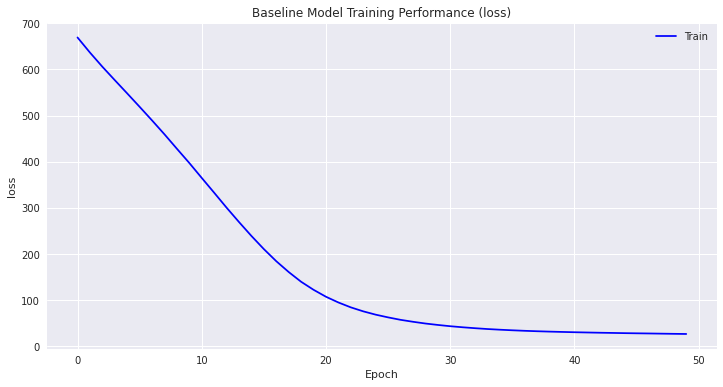

In [33]:
# Summarize model training hisotry
fig, axs = plt.subplots(1, 1, figsize=(12,6))
plt.subplot(111)
plt.plot(baseline_hist.history[train_metric], color='blue', label='train')
plt.title('Baseline Model Training Performance (%s)' % (train_metric))
plt.ylabel(train_metric)
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [34]:
if (notifyStatus): status_notify("Task 3. Define and Train Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 4. Evaluate and Optimize Model

In [35]:
if (notifyStatus): status_notify("Task 4. Evaluate and Optimize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [36]:
# Define the Keras model required for KerasClassifier
def create_customized_model(optimizer, kernel_init):
    customized_model = Sequential()
    customized_model.add(Dense(25, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=kernel_init))
    customized_model.add(Dense(1, kernel_initializer=kernel_init))
    customized_model.compile(loss=default_loss, optimizer=optimizer)
    return customized_model

In [37]:
startTimeModule = datetime.now()

# Set up grid search using different epochs, batch sizes, and optimizers
optz_1 = tf.keras.optimizers.Adam(learning_rate=0.001)
optz_2 = tf.keras.optimizers.RMSprop(learning_rate=0.001)
optz_3 = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer_grid = [optz_1, optz_2, optz_3]
print('Optimizer candidate #1 has the object ID of', optz_1)
print('Optimizer candidate #2 has the object ID of', optz_2)
print('Optimizer candidate #3 has the object ID of', optz_3)

init_1 = tf.keras.initializers.he_uniform(seed=seedNum)
init_2 = tf.keras.initializers.Orthogonal(seed=seedNum)
init_3 = tf.keras.initializers.RandomUniform(seed=seedNum)
init_grid = [init_1, init_2, init_3]
print('Initializer candidate #1 has the object ID of', init_1)
print('Initializer candidate #2 has the object ID of', init_2)
print('Initializer candidate #3 has the object ID of', init_3)

epoch_grid = [default_epoch]
batch_grid = [int(default_batch/2), default_batch, int(default_batch*2)]

best_score = float('inf')
grid_iteration = 0
best_iteration = 0
best_optimizer = default_optimizer
best_kernel_init = default_kernel_init
best_epoch = default_epoch
best_batch = default_batch

for optimizer in optimizer_grid:
    for kernel_init in init_grid:
        for epoch_num in epoch_grid:
            for batch_num in batch_grid:
                print('\nForming the grid-search model #%d using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
                      % (grid_iteration, optimizer, kernel_init, epoch_num, batch_num))
                reset_random(seedNum)
                grid_model = create_customized_model(optimizer, kernel_init)
                grid_hist = grid_model.fit(X_train, y_train, epochs=epoch_num, batch_size=batch_num, validation_data=(X_validation, y_validation), verbose=1)
                if(grid_hist.history['val_loss'][-1] < best_score):
                    best_score = grid_hist.history['val_loss'][-1]
                    best_iteration = grid_iteration
                    best_optimizer = optimizer
                    best_kernel_init = kernel_init
                    best_epoch = epoch_num
                    best_batch = batch_num
                grid_iteration = grid_iteration + 1

# summarize results
print("\nBest score (lowest validation loss) found via grid search: loss=%f RMSE=%f from model iteration #%d"
      % (best_score, math.sqrt(best_score), best_iteration))
print('The best modeling parameters are: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
      % (best_optimizer, best_kernel_init, best_epoch, best_batch))
print('Total time for performing grid-search of the best parameters:', (datetime.now() - startTimeModule))

Optimizer candidate #1 has the object ID of <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f23f8f89110>
Optimizer candidate #2 has the object ID of <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x7f2404b38ad0>
Optimizer candidate #3 has the object ID of <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f23fa74efd0>
Initializer candidate #1 has the object ID of <tensorflow.python.ops.init_ops_v2.VarianceScaling object at 0x7f23fc83b690>
Initializer candidate #2 has the object ID of <tensorflow.python.ops.init_ops_v2.Orthogonal object at 0x7f23fc83ba10>
Initializer candidate #3 has the object ID of <tensorflow.python.ops.init_ops_v2.RandomUniform object at 0x7f23f8fbeb90>

Forming the grid-search model #0 using: optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f23f8f89110>, kernel=<tensorflow.python.ops.init_ops_v2.VarianceScaling object at 0x7f23fc83b690>, epochs=50, batch_size=8
Epoch 1/50
48/48 [==============

In [38]:
if (notifyStatus): status_notify("Task 4. Evaluate and Optimize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Task 5. Finalize Model and Make Predictions

In [39]:
if (notifyStatus): status_notify("Task 5. Finalize Model and Make Predictions has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [40]:
final_optimizer = best_optimizer
final_kernel_init = best_kernel_init
final_epoch = best_epoch
final_batch = best_batch

In [41]:
# Create the final model for evaluating the test dataset
print('Forming the final model using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
      % (final_optimizer, final_kernel_init, final_epoch, final_batch))
reset_random(seedNum)
final_model = create_customized_model(final_optimizer, final_kernel_init)
final_hist = final_model.fit(X_train, y_train, epochs=final_epoch, batch_size=final_batch, validation_data=(X_validation, y_validation), verbose=1)

Forming the final model using: optimizer=<tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f23fa74efd0>, kernel=<tensorflow.python.ops.init_ops_v2.Orthogonal object at 0x7f23fc83ba10>, epochs=50, batch_size=8
Epoch 1/50
48/48 [==============================] - 0s 6ms/step - loss: 81.0147 - val_loss: 18.2518
Epoch 2/50
48/48 [==============================] - 0s 3ms/step - loss: 23.2047 - val_loss: 15.4419
Epoch 3/50
48/48 [==============================] - 0s 4ms/step - loss: 27.3624 - val_loss: 17.4510
Epoch 4/50
48/48 [==============================] - 0s 4ms/step - loss: 21.1785 - val_loss: 54.3475
Epoch 5/50
48/48 [==============================] - 0s 9ms/step - loss: 19.5575 - val_loss: 14.5242
Epoch 6/50
48/48 [==============================] - 0s 4ms/step - loss: 18.3156 - val_loss: 12.6293
Epoch 7/50
48/48 [==============================] - 0s 4ms/step - loss: 16.1560 - val_loss: 21.1128
Epoch 8/50
48/48 [==============================] - 0s 4ms/step - los

In [42]:
# Display a summary of the final model
print(final_model.summary())

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 25)                350       
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 26        
Total params: 376
Trainable params: 376
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
# Display the configuration of the final model
print(final_model.get_config())

{'name': 'sequential_28', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense_56', 'trainable': True, 'batch_input_shape': (None, 13), 'dtype': 'float32', 'units': 25, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_57', 'trainable': True, 'dtype': 'float32', 'units': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}], 'build_input_shape': TensorShape([None, 13])}


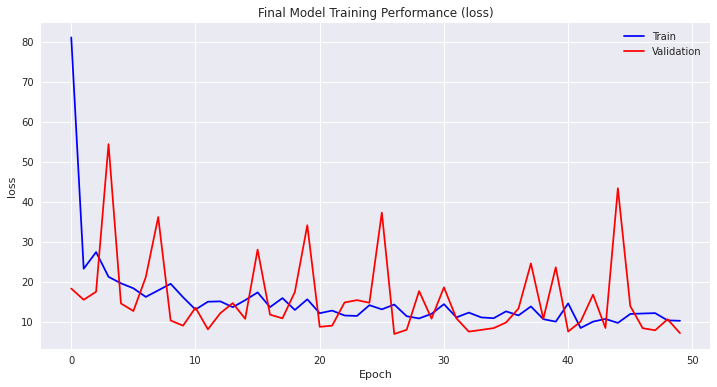

In [44]:
# Summarize model training hisotry
fig, axs = plt.subplots(1, 1, figsize=(12,6))
plt.subplot(111)
plt.plot(final_hist.history[train_metric], color='blue', label='train')
plt.plot(final_hist.history[validation_metric], color='red', label='validation')
plt.title('Final Model Training Performance (%s)' % (train_metric))
plt.ylabel(train_metric)
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [45]:
# In the absence of a brand new test dataset, we will use the same validation dataset as a substitute
X_test = X_validation
y_test = y_validation

In [46]:
# Evaluate the Keras model on previously unseen data
scores = final_model.evaluate(X_test, y_test)
print("Final MSE of the model: %f" % (scores))
print("Final RMSE of the model: %f" % (math.sqrt(scores)))

4/4 [==============================] - 0s 2ms/step - loss: 7.1031
Final MSE of the model: 7.103058
Final RMSE of the model: 2.665156


In [47]:
# Make class predictions with the model
predictions = final_model.predict(X_test)

# Summarize the first 20 cases
for i in range(20):
	print('Data item #%d predicted to be %.2f (expected %.2f)' % (i, predictions[i], y_test[i]))

Data item #0 predicted to be 24.33 (expected 22.40)
Data item #1 predicted to be 34.75 (expected 32.40)
Data item #2 predicted to be 19.05 (expected 21.70)
Data item #3 predicted to be 21.07 (expected 24.50)
Data item #4 predicted to be 22.87 (expected 16.80)
Data item #5 predicted to be 20.84 (expected 21.10)
Data item #6 predicted to be 27.50 (expected 29.40)
Data item #7 predicted to be 25.73 (expected 28.70)
Data item #8 predicted to be 24.05 (expected 21.50)
Data item #9 predicted to be 13.64 (expected 13.60)
Data item #10 predicted to be 21.49 (expected 21.40)
Data item #11 predicted to be 23.30 (expected 24.80)
Data item #12 predicted to be 18.69 (expected 16.80)
Data item #13 predicted to be 18.80 (expected 19.40)
Data item #14 predicted to be 23.06 (expected 21.70)
Data item #15 predicted to be 14.52 (expected 17.20)
Data item #16 predicted to be 13.99 (expected 17.10)
Data item #17 predicted to be 20.24 (expected 18.70)
Data item #18 predicted to be 21.56 (expected 22.30)
Dat

In [48]:
if (notifyStatus): status_notify("Task 5. Finalize Model and Make Predictions completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [49]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:03:59.266850
